In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from model import LightningUNET
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import random
from torchmetrics import JaccardIndex

datapath = '/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/'
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 16
LEARNING_RATE = 0.001
EPOCHS = 1000
DATALOADER_WORKERS = 10

In [34]:
channel_mins = torch.tensor([26.8503,  0.1685, -8.2685, -1.4102, -1.1436, -0.1486,  0.0375,  0.2940,
         0.7091,  1.0280,  2.7341, 10.9818,  7.9130, 10.6544, 14.0237, 17.8245])
channel_maxs = torch.tensor([373.6197, 313.2299, 199.4103,   3.8946,  30.4704,   6.4709,   0.8165,
          3.5764,   9.9501,  15.6381,  45.9991,  37.7118,  80.0275,  92.6629,
        100.9954,  85.6070])

In [3]:
# ABI Chip Loader
class AbiChipDataset(Dataset):
    def __init__(self, chip_paths):
        self.chip_paths = chip_paths

    def __len__(self):
        return len(self.chip_paths)

    def __getitem__(self, idx):
        chip = np.load(self.chip_paths[idx], allow_pickle=True)
        image = torch.from_numpy(chip['chip'])
        image = (image - channel_mins) / (channel_maxs - channel_mins)
        image = image.permute(2, 0, 1).float()
        mask = torch.from_numpy(chip['data'].item()['Cloud_mask_binary']).unsqueeze(0).float()

        return (image, mask)

In [15]:
total_chips = glob.glob(datapath + "*.npz")

chip_sample = random.sample(total_chips, 2000)

channel_mins = torch.zeros(16) + 10000
channel_maxs = torch.zeros(16)

In [16]:
totaldata = []
for i in range(IMG_CHANNELS):
    totaldata.append([])

In [17]:
for chippath in chip_sample:
    chip = np.load(chippath, allow_pickle=False)
    image = torch.from_numpy(chip['chip'])
    #image = (image - channel_mins) / (channel_maxs - channel_mins)
    image = image.permute(2, 0, 1).float()
    for channel in range(IMG_CHANNELS):
        for val in image[channel].flatten():
            totaldata[channel].append(val)

In [12]:
print(channel_mins)
print(channel_maxs)

tensor([26.8503,  0.1685, -8.2685, -1.4102, -1.1436, -0.1486,  0.0375,  0.2940,
         0.7091,  1.0280,  2.7341, 10.9818,  7.9130, 10.6544, 14.0237, 17.8245])
tensor([373.6197, 313.2299, 199.4103,   3.8946,  30.4704,   6.4709,   0.8165,
          3.5764,   9.9501,  15.6381,  45.9991,  37.7118,  80.0275,  92.6629,
        100.9954,  85.6070])


In [18]:
totaldata = torch.Tensor(totaldata)
# totaldata = (totaldata * (channel_maxs - channel_mins)) + channel_mins

In [20]:
for channel in range(IMG_CHANNELS):
    print(torch.min(totaldata[channel]), torch.max(totaldata[channel]))

tensor(31.7229) tensor(804.0361)
tensor(0.9615) tensor(628.9872)
tensor(-8.2685) tensor(373.1670)
tensor(-1.4102) tensor(76.3233)
tensor(-0.9520) tensor(94.8480)
tensor(-0.1185) tensor(29.7895)
tensor(0.0406) tensor(8.3207)
tensor(0.3224) tensor(6.9156)
tensor(0.7767) tensor(16.8696)
tensor(1.2084) tensor(25.6788)
tensor(2.8342) tensor(103.7081)
tensor(11.0362) tensor(77.9974)
tensor(7.9130) tensor(158.6356)
tensor(10.6544) tensor(174.3746)
tensor(14.2875) tensor(178.8900)
tensor(18.8808) tensor(132.4386)


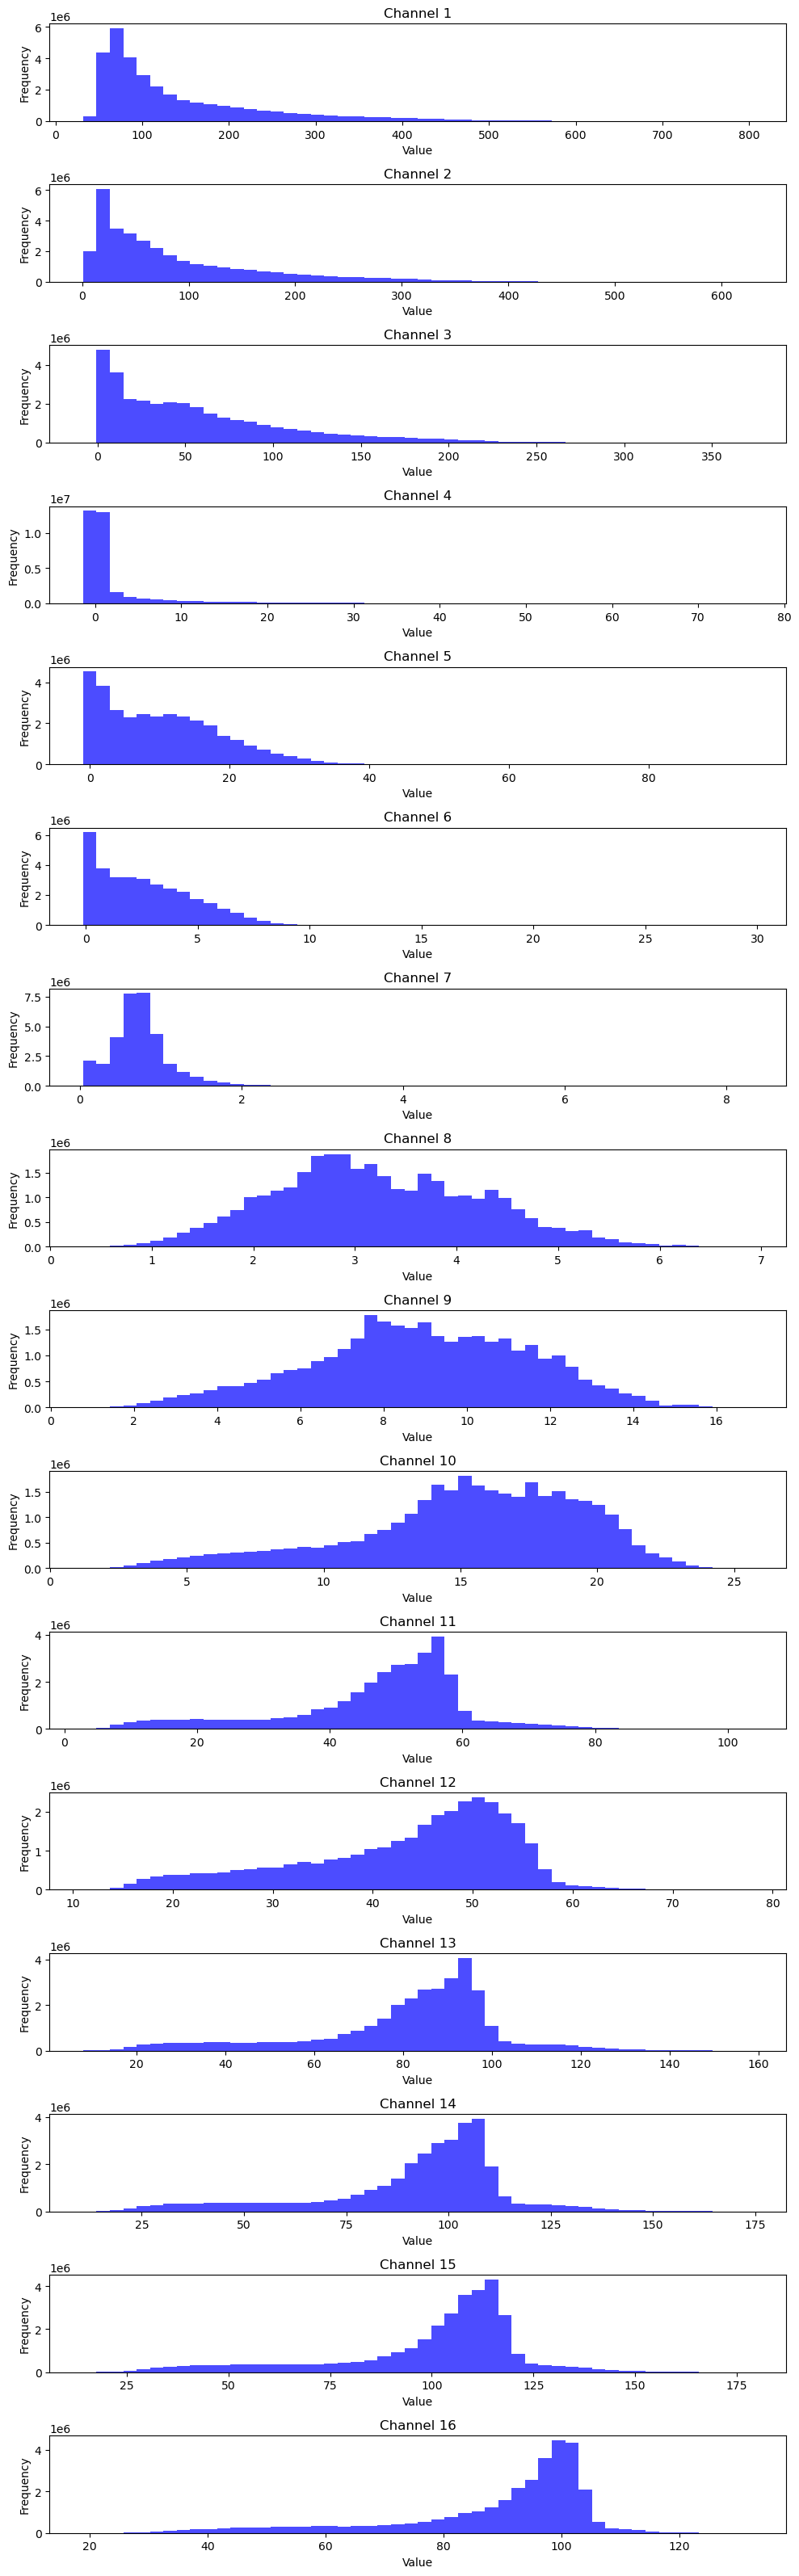

In [21]:
fig, axs = plt.subplots(IMG_CHANNELS, 1, figsize=(10, IMG_CHANNELS*2))

for i in range(IMG_CHANNELS):
    axs[i].hist(totaldata[i].numpy(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Channel {i+1}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
class AbiDataModule(pl.LightningDataModule):
    def __init__(self, chip_dir = datapath, batch_size = BATCH_SIZE):
        super().__init__()
        self.chip_dir = chip_dir
        self.batch_size = batch_size

    def setup(self, stage):
        total_chips = glob.glob(self.chip_dir + "*.npz")
        train_idx = int(len(total_chips) * 0.8)
        val_idx = int(len(total_chips) * 0.9)
        self.train_dataset = AbiChipDataset(total_chips[:train_idx])
        self.val_dataset = AbiChipDataset(total_chips[train_idx:val_idx])
        self.test_dataset = AbiChipDataset(total_chips[val_idx:])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size = self.batch_size, num_workers=DATALOADER_WORKERS)

In [13]:
pl.seed_everything(42, workers=True)

# unet = LightningUNET(in_channels=IMG_CHANNELS, classes=1, learning_rate=LEARNING_RATE)
unet = LightningUNET.load_from_checkpoint("/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/july22iou.507.ckpt", in_channels=16)

# lr_scheduler = pl.callbacks.LearningRateMonitor(logging_interval='epoch')
early_stopping = pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", mode="min", patience=10)

datamodule = AbiDataModule(datapath, BATCH_SIZE)

trainer = pl.Trainer(
    deterministic=True,
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    callbacks=[early_stopping],
    default_root_dir="/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/"
)

# trainer.fit(model=unet, datamodule=datamodule)

[rank: 0] Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.test(model=unet, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: 0it [00:15, ?it/s]
Testing DataLoader 0: 100%|██████████| 75/75 [00:05<00:00, 14.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_iou          │    0.4793775975704193     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou': 0.4793775975704193}]

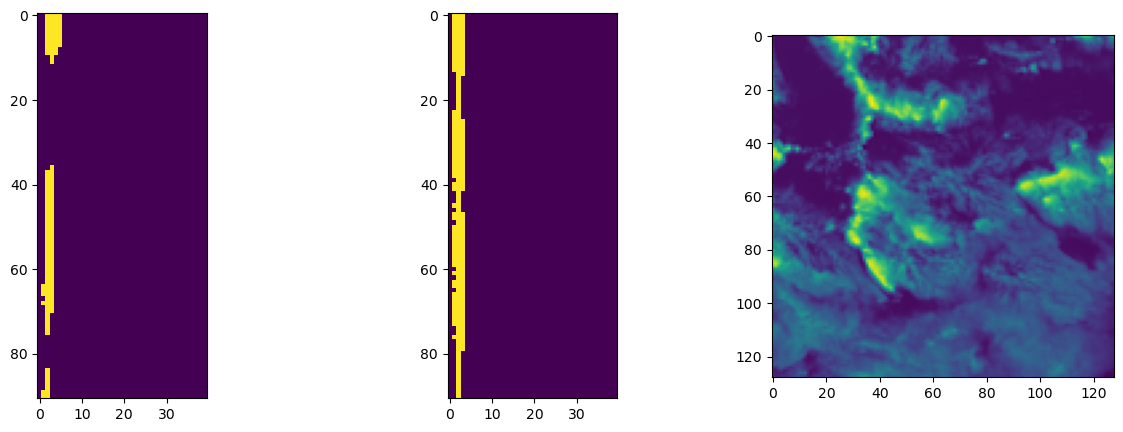

2019-350-72638_7981-3392-6510.npz
tensor(0.4226)
tensor(0.2720, grad_fn=<AddBackward0>)


In [32]:
filename = "2019-350-72638_7981-3392-6510.npz"
sample_chip = np.load(f"/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/GOES-16/{filename}", allow_pickle=True)
data = torch.from_numpy(sample_chip['chip'])
pred = unet.forward(data.permute(2, 0, 1).unsqueeze(0))
fig, axs = plt.subplots(1,3, figsize=(15, 5))


truth = torch.from_numpy(sample_chip['data'].item()['Cloud_mask_binary']).unsqueeze(0).unsqueeze(0).float()


ce = unet.ce_loss(pred, truth)
dice = unet.dice_loss(pred, truth)
loss = unet.dice_weight * dice + (1 - unet.dice_weight) * ce
pred = torch.sigmoid(pred) > 0.5


pred = pred.squeeze()
truth = truth.squeeze()
axs[0].imshow(pred)
axs[1].imshow(truth)
axs[2].imshow(data[:, :, 2])
plt.show()
print(filename)
print(unet.iou(pred, truth))
print(loss)

In [8]:
trainer.save_checkpoint("/explore/nobackup/projects/pix4dcloud/szhang16/checkpoints/july22training-fulldata.ckpt")

array([20.21512255, 20.21507812, 20.21503364, 20.21498922, 20.2149448 ,
       20.21490031, 20.21485589, 20.21481147, 20.21476698, 20.21472256,
       20.21467814, 20.21463365, 20.21458923, 20.21454475, 20.21450033,
       20.21445591, 20.21441142, 20.214367  , 20.21432258, 20.21427809,
       20.21423367, 20.21418925, 20.21414476, 20.21410034, 20.21405585,
       20.21401143, 20.21396701, 20.21392253, 20.21387811, 20.21383369,
       20.2137892 , 20.21374478, 20.21370036, 20.21365587, 20.21361145,
       20.21356703, 20.21352254, 20.21347812, 20.21343363, 20.21338921,
       20.21334479, 20.21330031, 20.21325589, 20.21321147, 20.21316698,
       20.21312256, 20.21307814, 20.21303365, 20.21298923, 20.21294474,
       20.21290032, 20.2128559 , 20.21281141, 20.21276699, 20.21272257,
       20.21267809, 20.21263367, 20.21258925, 20.21254476, 20.21250034,
       20.21245592, 20.21241143, 20.21236701, 20.21232252, 20.2122781 ,
       20.21223368, 20.2121892 , 20.21214478, 20.21210036, 20.21

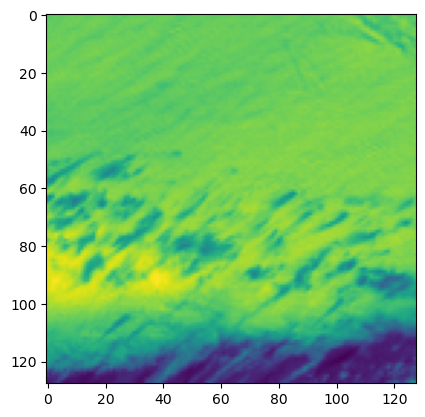

In [8]:
sample_chip = np.load("/explore/nobackup/projects/pix4dcloud/szhang16/abiChips/bad-chips/2019-310-72053_1609-3358-13145.npz", allow_pickle=True)
plt.imshow(sample_chip['chip'][:, :, 0])
sample_chip['data'].item()['UTC_Time']